# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [ ]:
!pip install wandb
!pip3 install pytorch_lightning torchmetrics

In [ ]:
import wandb

# логинимся в wandb
wandb.login()

wandb: Currently logged in as: rubanoww. Use `wandb login --relogin` to force relogin


True

In [1]:
import math
import os
import random
import sys
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as T
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [ ]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

dataset.zip         100%[===================>] 210.11M  14.5MB/s    in 13s     

2022-11-03 19:20:34 (15.7 MB/s) - ‘dataset.zip’ saved [220318689/220318689]



In [3]:
# проверим device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
# узнать, какой GPU

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov  2 22:26:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    44W / 400W |      3MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True) 

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели. 
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать: 

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали. 
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

Для того, чтобы сделать правильную нормализацию, посчитаем среднее значение и стандартное отклонение по каждому из каналов обучающей выборки. Создадим для этого отдельный датасет без каких-либо преобразований.

In [ ]:
# найдем среднее значение и стандартное отклонение по каждому из каналов
# идея взята из: https://www.pluralsight.com/guides/image-classification-with-pytorch

train_transform_clear = T.Compose([
    T.ToTensor() # без преобразований, картинки как есть
])

train_dataset_clear = ImageFolder('/content/dataset/dataset/train', transform=train_transform_clear)  # для поиска mean и std

means = torch.zeros(1, 3).squeeze()
stds = torch.zeros(1, 3).squeeze()

for image, _ in train_dataset_clear:
    means += image.mean(dim = (1,2)) # суммируем средние
    stds += image.std(dim = (1,2))   # суммируем станд. откл.

In [ ]:
print(means / len(train_dataset_clear)) # делим средние на размер датасета
print(stds / len(train_dataset_clear))  # делим станд. откл. на размер датасета

tensor([0.4802, 0.4481, 0.3975])
tensor([0.2302, 0.2265, 0.2262])


In [ ]:
train_transform = T.Compose([
    T.RandomApply(torch.nn.ModuleList([  # изначально был выбор из нескольких аугментаций, но я оставил только RandomHorizontalFlip
        T.RandomHorizontalFlip()         # и оставил конструкцию выбора из нескольких аугментаций (сейчас здесь выбирается только RandomHorizontalFlip)
        ]), 
        p=1),
    T.AutoAugment(T.AutoAugmentPolicy.IMAGENET), # делаем "классические" для IMAGENET аугментации: Posterize, Rotate, Solarize, AutoContrast, Contrast,
                                                 #                                                 Equalize, Color, Invert, Sharpness, ShearX
    T.ToTensor(),
    T.Normalize(
        mean=[0.4802, 0.4481, 0.3975],
        std=[0.2302, 0.2265, 0.2262],
    )
])

val_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[0.4802, 0.4481, 0.3975],  # не применяем аугментации для валидации
        std=[0.2302, 0.2265, 0.2262],
    )
]) 

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform) # colab: '/content/dataset/dataset/train'
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)       # colab: '/content/dataset/dataset/val'

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True,
    num_workers=8,  # 12 in colab / 8 locally
    pin_memory=True)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=64, 
    shuffle=False,
    num_workers=8,  # 12 in colab / 8 locally
    pin_memory=True)

Для некоторых тестов и отладок определим *сокращенный датасет* из n объектов:

In [ ]:
# сделаем подвыборку, источник: https://stackoverflow.com/questions/50798172/pytorch-how-to-make-the-trainloader-use-a-specific-amount-of-images

class LimitDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, n):
        self.dataset = dataset
        self.n = n

    def __len__(self):
        return self.n

    def __getitem__(self, i):
        return self.dataset[i]

In [ ]:
# ограниченные датасеты и даталодеры из 256 картинок для отладки кода 

limit_train_dataset = LimitDataset(train_dataset, n=256)
limit_val_dataset = LimitDataset(val_dataset, n=256)

limit_train_dataloader = DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True,
    num_workers=8,
    pin_memory=True)

limit_val_dataloader = DataLoader(
    val_dataset, 
    batch_size=64, 
    shuffle=False,
    num_workers=8,
    pin_memory=True)

In [ ]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

In [ ]:
# for batch in val_dataloader:
#     images, class_nums = batch
#     plt.imshow(images[5].permute(1, 2, 0))
#     plt.show()
#     plt.imshow(images[19].permute(1, 2, 0))
#     plt.show()
#     break

Возьмем код из 3 семинара, чтобы смотреть на много картинок сразу:

In [ ]:
def matplotlib_imshow(img, one_channel=False): # из 3 семинара
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

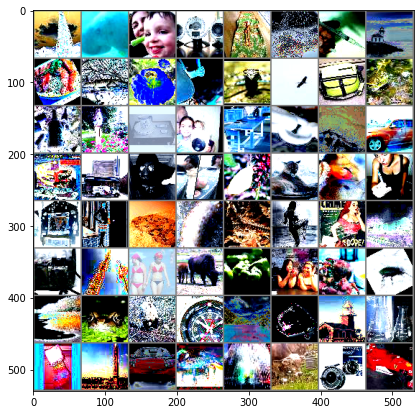

In [ ]:
images, labels = next(iter(train_dataloader)) # из 3 семинара

plt.figure(figsize=(7,7))
# create grid of images
img_grid = torchvision.utils.make_grid(images)
# show images
matplotlib_imshow(img_grid, one_channel=False)

## Задание 1. 

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

Импортируем непредобученную модель ResNet с 18 слоями.

In [ ]:
from torchvision.models import resnet18

Посмотрим на нее:

In [ ]:
model = resnet18(pretrained=False, num_classes=200).to(device)
model

c:\Users\Admin\AppData\Local\R-MINI~1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\AppData\Local\R-MINI~1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Определим **класс модели**:

In [ ]:
# берем в качестве основы непредобученную resnet
# шаблон взят из семинара № 4

class MyNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = resnet18(pretrained=False, num_classes=200)  # не нужно корректировать число выходов
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        x = self.model(x)
        return x

    def forward(self, images, target=None):
        output = self._forward(images)

        # get accuracy score and save it to self.accuracy
        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long())

        return loss

    def get_accuracy(self, reset=False):
        # return accuracy by all values till now
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

### Тренировочный класс lightning

Определим модуль Lightning.

In [ ]:
# источник для интеграции логера wandb: https://docs.wandb.ai/guides/integrations/lightning
# шаблон взят из семинара № 4

class MyModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

        # сохраняем гиперпараметры в self.hparams (автоматически логируется в wandb)
        self.save_hyperparameters(ignore=['model']) # (ignore=['model']), т.к. wandb и так следит за моделью

    def forward(self, x):
        result = self.model(x)
        
        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=0.0001)  # добавим небольшую регуляризацию
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0,
                                                      max_lr=0.001,
                                                      step_size_up=3, 
                                                      step_size_down=4500,   # lr возрастает приблизительно каждую 3-ю эпоху
                                                      verbose=True,          # иллюстрация работы scheduler есть в отчете ниже
                                                      mode='triangular2',    # идея для optimizer и scheduler взята в
                                                      cycle_momentum=False)  # следующем исследовании: http://cs231n.stanford.edu/reports/2017/pdfs/937.pdf 
        lr_scheduler_config = {        # определяем настройки scheduler
            "scheduler": scheduler,    # передаем scheduler
            "interval": "step",        # 'step' / 'epoch'
            "frequency": 1,            # Сколько эпох/шагов должно пройти между вызовами функции `scheduler.step()`
            "monitor": "val_accuracy", # метрика для мониторинга scheduler типо `ReduceLROnPlateau`
            "strict": True,            # остановка обучения, если не найдена метрика для мониторинга
            "name": None,              # a custom logged name
        }
        opt_sched_dict = {
            "optimizer" : optimizer,
            "lr_scheduler" : lr_scheduler_config 
            }

        return opt_sched_dict

    def training_step(self, batch, batch_idx):
        '''возвращаем loss из одного батча'''
        # получаем предсказанные значения, loss и метрику accuracy
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # логируем loss и метрику в wandb
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_accuracy", acc, prog_bar=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        '''используется для логирования метрик на валидации'''
        # получаем предсказанные значения, loss и метрику accuracy
        preds, loss, acc = self._get_preds_loss_accuracy(batch)

        # логируем loss и метрику в wandb
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", acc, prog_bar=True)

        return preds

    def _get_preds_loss_accuracy(self, batch):
        '''функция для получения предсказанных значений, loss и метрики accuracy'''
        x, y = batch
        preds = self.model._forward(x)
        loss = self.model(x, y)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), y.long())

        return preds, loss, acc

### Logger W&B

Далее определим логер с помощью **wandb**, а также попросим выдавать таблицу с реальными классами и нашими предсказаниями на валидации:

In [ ]:
# определим логер, источник: https://docs.wandb.ai/guides/integrations/lightning

wandb_logger = WandbLogger(
    project='hw-2',
    name='test-1',
    version='resnet-1',
    log_model='all')

# условие для сохранения модели: наибольшее значение метрики accuracy на валидации
checkpoint_callback = ModelCheckpoint(monitor='val_accuracy', mode='max') 

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rubanoww. Use `wandb login --relogin` to force relogin


In [ ]:
# источник: https://docs.wandb.ai/guides/integrations/lightning

from pytorch_lightning.callbacks import Callback
 
class LogPredictionsCallback(Callback):
    
    def on_validation_batch_end(
        self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx):
        """Вызывается, когда батч на валидации заканчивается"""
 
        # `outputs` приходят из `LightningModule.validation_step`
        # что соответствует предсказаниям модели
        
        # будем логировать 20 предсказаний на валидации из первого батча
        if batch_idx == 0:
            n = 20
            x, y = batch
            images = [img for img in x[:n]]
            captions = [f'Ground Truth: {y_i} - Prediction: {torch.argmax(y_pred).item()}' for y_i, y_pred in zip(y[:n], outputs[:n])]

            # Option 1: log images with `WandbLogger.log_image`
            wandb_logger.log_image(key='sample_images', images=images, caption=captions) 

            # Option 2 интересный, но выдает ошибку, с которой я не смог разобраться. Ограничимся Option 1
            # # Option 2: log predictions as a Table
            # columns = ['image', 'ground truth', 'prediction']
            # data = [[wandb.Image(x_i), y_i, y_pred] for x_i, y_i, y_pred in list(zip(x[:n], y[:n], outputs[:n]))]
            # wandb_logger.log_table(key='sample_table', columns=columns, data=data)

log_predictions_callback = LogPredictionsCallback()

### Тренировка

In [ ]:
# создадим модель и модуль pl.LightningModule
# попросим логер следить за моделью

model = MyNet().to(device)
wandb_logger.watch(model, log="all")

module = MyModule(
    model,
    learning_rate=0.001
)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
# определим pl.Trainer

trainer = pl.Trainer(
    logger=wandb_logger,
    callbacks=[log_predictions_callback,
               checkpoint_callback],
    max_epochs=10,
    accelerator="gpu",
    auto_lr_find=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(module, train_dataloader, val_dataloader)  # прошу прощения за большую выдачу; ставить `verbose=True` было ошибкой

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Adjusting learning rate of group 0 to 0.0000e+00.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.19054607179632482
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_29e5d774-3e61-41fa-9800-0e9a9ee348f4.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type  | Params
--------------------------------
0 | model | MyNet | 11.3 M
--------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.116    Total estimated model params size (MB)


Adjusting learning rate of group 0 to 0.0000e+00.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.3333e-04.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.9978e-04.
Adjusting learning rate of group 0 to 9.9956e-04.
Adjusting learning rate of group 0 to 9.9933e-04.
Adjusting learning rate of group 0 to 9.9911e-04.
Adjusting learning rate of group 0 to 9.9889e-04.
Adjusting learning rate of group 0 to 9.9867e-04.
Adjusting learning rate of group 0 to 9.9844e-04.
Adjusting learning rate of group 0 to 9.9822e-04.
Adjusting learning rate of group 0 to 9.9800e-04.
Adjusting learning rate of group 0 to 9.9778e-04.
Adjusting learning rate of group 0 to 9.9756e-04.
Adjusting learning rate of group 0 to 9.9733e-04.
Adjusting learning rate of group 0 to 9.9711e-04.
Adjusting learning rate of group 0 to 9.9689e-04.
Adjusting learning rate of group 0 to 9.9667e-04.
Adjusting learning rate of group 0 to 9.9644e-04.
Adjusting learning rate of group 0 to 9.9622e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.5311e-04.
Adjusting learning rate of group 0 to 6.5289e-04.
Adjusting learning rate of group 0 to 6.5267e-04.
Adjusting learning rate of group 0 to 6.5244e-04.
Adjusting learning rate of group 0 to 6.5222e-04.
Adjusting learning rate of group 0 to 6.5200e-04.
Adjusting learning rate of group 0 to 6.5178e-04.
Adjusting learning rate of group 0 to 6.5156e-04.
Adjusting learning rate of group 0 to 6.5133e-04.
Adjusting learning rate of group 0 to 6.5111e-04.
Adjusting learning rate of group 0 to 6.5089e-04.
Adjusting learning rate of group 0 to 6.5067e-04.
Adjusting learning rate of group 0 to 6.5044e-04.
Adjusting learning rate of group 0 to 6.5022e-04.
Adjusting learning rate of group 0 to 6.5000e-04.
Adjusting learning rate of group 0 to 6.4978e-04.
Adjusting learning rate of group 0 to 6.4956e-04.
Adjusting learning rate of group 0 to 6.4933e-04.
Adjusting learning rate of group 0 to 6.4911e-04.
Adjusting learning rate of group 0 to 6.4889e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.0578e-04.
Adjusting learning rate of group 0 to 3.0556e-04.
Adjusting learning rate of group 0 to 3.0533e-04.
Adjusting learning rate of group 0 to 3.0511e-04.
Adjusting learning rate of group 0 to 3.0489e-04.
Adjusting learning rate of group 0 to 3.0467e-04.
Adjusting learning rate of group 0 to 3.0444e-04.
Adjusting learning rate of group 0 to 3.0422e-04.
Adjusting learning rate of group 0 to 3.0400e-04.
Adjusting learning rate of group 0 to 3.0378e-04.
Adjusting learning rate of group 0 to 3.0356e-04.
Adjusting learning rate of group 0 to 3.0333e-04.
Adjusting learning rate of group 0 to 3.0311e-04.
Adjusting learning rate of group 0 to 3.0289e-04.
Adjusting learning rate of group 0 to 3.0267e-04.
Adjusting learning rate of group 0 to 3.0244e-04.
Adjusting learning rate of group 0 to 3.0222e-04.
Adjusting learning rate of group 0 to 3.0200e-04.
Adjusting learning rate of group 0 to 3.0178e-04.
Adjusting learning rate of group 0 to 3.0156e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.7956e-04.
Adjusting learning rate of group 0 to 4.7944e-04.
Adjusting learning rate of group 0 to 4.7933e-04.
Adjusting learning rate of group 0 to 4.7922e-04.
Adjusting learning rate of group 0 to 4.7911e-04.
Adjusting learning rate of group 0 to 4.7900e-04.
Adjusting learning rate of group 0 to 4.7889e-04.
Adjusting learning rate of group 0 to 4.7878e-04.
Adjusting learning rate of group 0 to 4.7867e-04.
Adjusting learning rate of group 0 to 4.7856e-04.
Adjusting learning rate of group 0 to 4.7844e-04.
Adjusting learning rate of group 0 to 4.7833e-04.
Adjusting learning rate of group 0 to 4.7822e-04.
Adjusting learning rate of group 0 to 4.7811e-04.
Adjusting learning rate of group 0 to 4.7800e-04.
Adjusting learning rate of group 0 to 4.7789e-04.
Adjusting learning rate of group 0 to 4.7778e-04.
Adjusting learning rate of group 0 to 4.7767e-04.
Adjusting learning rate of group 0 to 4.7756e-04.
Adjusting learning rate of group 0 to 4.7744e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.0589e-04.
Adjusting learning rate of group 0 to 3.0578e-04.
Adjusting learning rate of group 0 to 3.0567e-04.
Adjusting learning rate of group 0 to 3.0556e-04.
Adjusting learning rate of group 0 to 3.0544e-04.
Adjusting learning rate of group 0 to 3.0533e-04.
Adjusting learning rate of group 0 to 3.0522e-04.
Adjusting learning rate of group 0 to 3.0511e-04.
Adjusting learning rate of group 0 to 3.0500e-04.
Adjusting learning rate of group 0 to 3.0489e-04.
Adjusting learning rate of group 0 to 3.0478e-04.
Adjusting learning rate of group 0 to 3.0467e-04.
Adjusting learning rate of group 0 to 3.0456e-04.
Adjusting learning rate of group 0 to 3.0444e-04.
Adjusting learning rate of group 0 to 3.0433e-04.
Adjusting learning rate of group 0 to 3.0422e-04.
Adjusting learning rate of group 0 to 3.0411e-04.
Adjusting learning rate of group 0 to 3.0400e-04.
Adjusting learning rate of group 0 to 3.0389e-04.
Adjusting learning rate of group 0 to 3.0378e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.3222e-04.
Adjusting learning rate of group 0 to 1.3211e-04.
Adjusting learning rate of group 0 to 1.3200e-04.
Adjusting learning rate of group 0 to 1.3189e-04.
Adjusting learning rate of group 0 to 1.3178e-04.
Adjusting learning rate of group 0 to 1.3167e-04.
Adjusting learning rate of group 0 to 1.3156e-04.
Adjusting learning rate of group 0 to 1.3144e-04.
Adjusting learning rate of group 0 to 1.3133e-04.
Adjusting learning rate of group 0 to 1.3122e-04.
Adjusting learning rate of group 0 to 1.3111e-04.
Adjusting learning rate of group 0 to 1.3100e-04.
Adjusting learning rate of group 0 to 1.3089e-04.
Adjusting learning rate of group 0 to 1.3078e-04.
Adjusting learning rate of group 0 to 1.3067e-04.
Adjusting learning rate of group 0 to 1.3056e-04.
Adjusting learning rate of group 0 to 1.3044e-04.
Adjusting learning rate of group 0 to 1.3033e-04.
Adjusting learning rate of group 0 to 1.3022e-04.
Adjusting learning rate of group 0 to 1.3011e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 2.2944e-04.
Adjusting learning rate of group 0 to 2.2939e-04.
Adjusting learning rate of group 0 to 2.2933e-04.
Adjusting learning rate of group 0 to 2.2928e-04.
Adjusting learning rate of group 0 to 2.2922e-04.
Adjusting learning rate of group 0 to 2.2917e-04.
Adjusting learning rate of group 0 to 2.2911e-04.
Adjusting learning rate of group 0 to 2.2906e-04.
Adjusting learning rate of group 0 to 2.2900e-04.
Adjusting learning rate of group 0 to 2.2894e-04.
Adjusting learning rate of group 0 to 2.2889e-04.
Adjusting learning rate of group 0 to 2.2883e-04.
Adjusting learning rate of group 0 to 2.2878e-04.
Adjusting learning rate of group 0 to 2.2872e-04.
Adjusting learning rate of group 0 to 2.2867e-04.
Adjusting learning rate of group 0 to 2.2861e-04.
Adjusting learning rate of group 0 to 2.2856e-04.
Adjusting learning rate of group 0 to 2.2850e-04.
Adjusting learning rate of group 0 to 2.2844e-04.
Adjusting learning rate of group 0 to 2.2839e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.4261e-04.
Adjusting learning rate of group 0 to 1.4256e-04.
Adjusting learning rate of group 0 to 1.4250e-04.
Adjusting learning rate of group 0 to 1.4244e-04.
Adjusting learning rate of group 0 to 1.4239e-04.
Adjusting learning rate of group 0 to 1.4233e-04.
Adjusting learning rate of group 0 to 1.4228e-04.
Adjusting learning rate of group 0 to 1.4222e-04.
Adjusting learning rate of group 0 to 1.4217e-04.
Adjusting learning rate of group 0 to 1.4211e-04.
Adjusting learning rate of group 0 to 1.4206e-04.
Adjusting learning rate of group 0 to 1.4200e-04.
Adjusting learning rate of group 0 to 1.4194e-04.
Adjusting learning rate of group 0 to 1.4189e-04.
Adjusting learning rate of group 0 to 1.4183e-04.
Adjusting learning rate of group 0 to 1.4178e-04.
Adjusting learning rate of group 0 to 1.4172e-04.
Adjusting learning rate of group 0 to 1.4167e-04.
Adjusting learning rate of group 0 to 1.4161e-04.
Adjusting learning rate of group 0 to 1.4156e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 5.5778e-05.
Adjusting learning rate of group 0 to 5.5722e-05.
Adjusting learning rate of group 0 to 5.5667e-05.
Adjusting learning rate of group 0 to 5.5611e-05.
Adjusting learning rate of group 0 to 5.5556e-05.
Adjusting learning rate of group 0 to 5.5500e-05.
Adjusting learning rate of group 0 to 5.5444e-05.
Adjusting learning rate of group 0 to 5.5389e-05.
Adjusting learning rate of group 0 to 5.5333e-05.
Adjusting learning rate of group 0 to 5.5278e-05.
Adjusting learning rate of group 0 to 5.5222e-05.
Adjusting learning rate of group 0 to 5.5167e-05.
Adjusting learning rate of group 0 to 5.5111e-05.
Adjusting learning rate of group 0 to 5.5056e-05.
Adjusting learning rate of group 0 to 5.5000e-05.
Adjusting learning rate of group 0 to 5.4944e-05.
Adjusting learning rate of group 0 to 5.4889e-05.
Adjusting learning rate of group 0 to 5.4833e-05.
Adjusting learning rate of group 0 to 5.4778e-05.
Adjusting learning rate of group 0 to 5.4722e-05.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 1.0956e-04.
Adjusting learning rate of group 0 to 1.0953e-04.
Adjusting learning rate of group 0 to 1.0950e-04.
Adjusting learning rate of group 0 to 1.0947e-04.
Adjusting learning rate of group 0 to 1.0944e-04.
Adjusting learning rate of group 0 to 1.0942e-04.
Adjusting learning rate of group 0 to 1.0939e-04.
Adjusting learning rate of group 0 to 1.0936e-04.
Adjusting learning rate of group 0 to 1.0933e-04.
Adjusting learning rate of group 0 to 1.0931e-04.
Adjusting learning rate of group 0 to 1.0928e-04.
Adjusting learning rate of group 0 to 1.0925e-04.
Adjusting learning rate of group 0 to 1.0922e-04.
Adjusting learning rate of group 0 to 1.0919e-04.
Adjusting learning rate of group 0 to 1.0917e-04.
Adjusting learning rate of group 0 to 1.0914e-04.
Adjusting learning rate of group 0 to 1.0911e-04.
Adjusting learning rate of group 0 to 1.0908e-04.
Adjusting learning rate of group 0 to 1.0906e-04.
Adjusting learning rate of group 0 to 1.0903e-04.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Мы обучили модель на 10 эпохах.

Проверим метрику на валидации.

In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_task(model, test_dataloader, device="cuda:0"):
    model = model.to(device)
    predicted_classes = torch.Tensor([]).to(device)
    true_classes = torch.Tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)

            pred = model._forward(images)
            pred_classes = torch.argmax(pred, dim=-1)

            predicted_classes = torch.cat((predicted_classes, pred_classes), 0)
            true_classes = torch.cat((true_classes, labels), 0)

    return accuracy_score(predicted_classes.cpu().detach().numpy(), true_classes.cpu().detach().numpy())

In [ ]:
evalmodel = model.to(device)

accuracy = evaluate_task(evalmodel, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

100%|██████████| 157/157 [00:02<00:00, 54.02it/s] 

Оценка за это задание составит 8.72 баллов


In [ ]:
accuracy

0.3838

Метрика *accuracy* получилась равной 0.3838, что достаточно мало. Можно попробовать *дообучить модель*, поскольку у нее есть потенциал.

Лучшая версия модели (последняя) была сохранена в *wandb*. Загрузим ее оттуда и **продолжим обучение**.

In [ ]:
# загрузим сохраненную модель из wandb

run = wandb.init(project="hw-2")
artifact = run.use_artifact('rubanoww/hw-2/model-resnet-1:v7', type='model')
artifact_dir = artifact.download()

wandb: Downloading large artifact model-resnet-1:v7, 129.22MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.2


Импортируем последнюю модель вместе со всеми параметрами.

In [ ]:
run = wandb.init(project="hw-2")
artifact = run.use_artifact('rubanoww/hw-2/model-resnet-1:v7', type='model')
artifact_dir = artifact.download()

wandb: Downloading large artifact model-resnet-1:v7, 129.22MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.5


In [ ]:
artifact_dir # чекпойнт лежит здесь

'./artifacts/model-resnet-1:v7'

In [ ]:
run.finish()

Загрузим модель и дообучим ее:

In [ ]:
newmodel = MyNet().to(device)

loaded_model = MyModule.load_from_checkpoint('/content/artifacts/model-resnet-1:v7/model.ckpt', model=newmodel, pretrained=True)

In [ ]:
wandb.login()

True

In [ ]:
# создадим новый логер
wandb_logger = WandbLogger(
    project='hw-2',
    name='test-1.2',
    version='resnet-1.2',
    log_model='all')

checkpoint_callback = ModelCheckpoint(monitor='val_accuracy', mode='max')

In [ ]:
# попросим новый логер следить за моделью
wandb_logger.watch(loaded_model,  log="all")

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
# создадим новый Trainer, будем учиться 5 эпох
newtrainer = pl.Trainer(
    logger=wandb_logger,
    callbacks=[log_predictions_callback,
               checkpoint_callback],
    max_epochs=5,
    accelerator="gpu")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Обучим еще **5 эпох**:

In [ ]:
newtrainer.fit(loaded_model, train_dataloader, val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type  | Params
--------------------------------
0 | model | MyNet | 11.3 M
--------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.116    Total estimated model params size (MB)


Adjusting learning rate of group 0 to 0.0000e+00.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.3333e-04.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.9978e-04.
Adjusting learning rate of group 0 to 9.9956e-04.
Adjusting learning rate of group 0 to 9.9933e-04.
Adjusting learning rate of group 0 to 9.9911e-04.
Adjusting learning rate of group 0 to 9.9889e-04.
Adjusting learning rate of group 0 to 9.9867e-04.
Adjusting learning rate of group 0 to 9.9844e-04.
Adjusting learning rate of group 0 to 9.9822e-04.
Adjusting learning rate of group 0 to 9.9800e-04.
Adjusting learning rate of group 0 to 9.9778e-04.
Adjusting learning rate of group 0 to 9.9756e-04.
Adjusting learning rate of group 0 to 9.9733e-04.
Adjusting learning rate of group 0 to 9.9711e-04.
Adjusting learning rate of group 0 to 9.9689e-04.
Adjusting learning rate of group 0 to 9.9667e-04.
Adjusting learning rate of group 0 to 9.9644e-04.
Adjusting learning rate of group 0 to 9.9622e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.5311e-04.
Adjusting learning rate of group 0 to 6.5289e-04.
Adjusting learning rate of group 0 to 6.5267e-04.
Adjusting learning rate of group 0 to 6.5244e-04.
Adjusting learning rate of group 0 to 6.5222e-04.
Adjusting learning rate of group 0 to 6.5200e-04.
Adjusting learning rate of group 0 to 6.5178e-04.
Adjusting learning rate of group 0 to 6.5156e-04.
Adjusting learning rate of group 0 to 6.5133e-04.
Adjusting learning rate of group 0 to 6.5111e-04.
Adjusting learning rate of group 0 to 6.5089e-04.
Adjusting learning rate of group 0 to 6.5067e-04.
Adjusting learning rate of group 0 to 6.5044e-04.
Adjusting learning rate of group 0 to 6.5022e-04.
Adjusting learning rate of group 0 to 6.5000e-04.
Adjusting learning rate of group 0 to 6.4978e-04.
Adjusting learning rate of group 0 to 6.4956e-04.
Adjusting learning rate of group 0 to 6.4933e-04.
Adjusting learning rate of group 0 to 6.4911e-04.
Adjusting learning rate of group 0 to 6.4889e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.0578e-04.
Adjusting learning rate of group 0 to 3.0556e-04.
Adjusting learning rate of group 0 to 3.0533e-04.
Adjusting learning rate of group 0 to 3.0511e-04.
Adjusting learning rate of group 0 to 3.0489e-04.
Adjusting learning rate of group 0 to 3.0467e-04.
Adjusting learning rate of group 0 to 3.0444e-04.
Adjusting learning rate of group 0 to 3.0422e-04.
Adjusting learning rate of group 0 to 3.0400e-04.
Adjusting learning rate of group 0 to 3.0378e-04.
Adjusting learning rate of group 0 to 3.0356e-04.
Adjusting learning rate of group 0 to 3.0333e-04.
Adjusting learning rate of group 0 to 3.0311e-04.
Adjusting learning rate of group 0 to 3.0289e-04.
Adjusting learning rate of group 0 to 3.0267e-04.
Adjusting learning rate of group 0 to 3.0244e-04.
Adjusting learning rate of group 0 to 3.0222e-04.
Adjusting learning rate of group 0 to 3.0200e-04.
Adjusting learning rate of group 0 to 3.0178e-04.
Adjusting learning rate of group 0 to 3.0156e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.7956e-04.
Adjusting learning rate of group 0 to 4.7944e-04.
Adjusting learning rate of group 0 to 4.7933e-04.
Adjusting learning rate of group 0 to 4.7922e-04.
Adjusting learning rate of group 0 to 4.7911e-04.
Adjusting learning rate of group 0 to 4.7900e-04.
Adjusting learning rate of group 0 to 4.7889e-04.
Adjusting learning rate of group 0 to 4.7878e-04.
Adjusting learning rate of group 0 to 4.7867e-04.
Adjusting learning rate of group 0 to 4.7856e-04.
Adjusting learning rate of group 0 to 4.7844e-04.
Adjusting learning rate of group 0 to 4.7833e-04.
Adjusting learning rate of group 0 to 4.7822e-04.
Adjusting learning rate of group 0 to 4.7811e-04.
Adjusting learning rate of group 0 to 4.7800e-04.
Adjusting learning rate of group 0 to 4.7789e-04.
Adjusting learning rate of group 0 to 4.7778e-04.
Adjusting learning rate of group 0 to 4.7767e-04.
Adjusting learning rate of group 0 to 4.7756e-04.
Adjusting learning rate of group 0 to 4.7744e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.0589e-04.
Adjusting learning rate of group 0 to 3.0578e-04.
Adjusting learning rate of group 0 to 3.0567e-04.
Adjusting learning rate of group 0 to 3.0556e-04.
Adjusting learning rate of group 0 to 3.0544e-04.
Adjusting learning rate of group 0 to 3.0533e-04.
Adjusting learning rate of group 0 to 3.0522e-04.
Adjusting learning rate of group 0 to 3.0511e-04.
Adjusting learning rate of group 0 to 3.0500e-04.
Adjusting learning rate of group 0 to 3.0489e-04.
Adjusting learning rate of group 0 to 3.0478e-04.
Adjusting learning rate of group 0 to 3.0467e-04.
Adjusting learning rate of group 0 to 3.0456e-04.
Adjusting learning rate of group 0 to 3.0444e-04.
Adjusting learning rate of group 0 to 3.0433e-04.
Adjusting learning rate of group 0 to 3.0422e-04.
Adjusting learning rate of group 0 to 3.0411e-04.
Adjusting learning rate of group 0 to 3.0400e-04.
Adjusting learning rate of group 0 to 3.0389e-04.
Adjusting learning rate of group 0 to 3.0378e-04.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Валидация:

In [ ]:
newevalmodel = newmodel.to(device)

accuracy = evaluate_task(newevalmodel, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

100%|██████████| 157/157 [00:02<00:00, 64.99it/s] 

Оценка за это задание составит 9.52 баллов


In [ ]:
accuracy

0.4188

Метрика `accuracy` равна 0.4188, что очень близко к требуемому значению. Попробуем еще немного улучшить модель. 

In [ ]:
wandb.finish()

Загрузим последнюю лучшую сохраненную модель:

In [ ]:
run = wandb.init(project="hw-2")
artifact = run.use_artifact('rubanoww/hw-2/model-resnet-1.2:v4', type='model')
artifact_dir = artifact.download()

wandb: Downloading large artifact model-resnet-1.2:v4, 129.22MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.4


In [ ]:
artifact_dir # модель лежит здесь

'./artifacts/model-resnet-1.2:v4'

In [ ]:
newmodel = MyNet().to(device)

loaded_model = MyModule.load_from_checkpoint('/content/artifacts/model-resnet-1.2:v4/model.ckpt', model=newmodel, pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
wandb.finish()

In [ ]:
# создадим новый логер
wandb_logger = WandbLogger(
    project='hw-2',
    name='test-1.4',
    version='resnet-1.4',
    log_model='all')

checkpoint_callback = ModelCheckpoint(monitor='val_accuracy', mode='max')

wandb_logger.watch(loaded_model,  log="all")

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
# создадим новый Trainer, будем учиться еще 5 эпох
newtrainer = pl.Trainer(
    logger=wandb_logger,
    callbacks=[log_predictions_callback,
               checkpoint_callback],
    max_epochs=5,
    accelerator="gpu")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Обучим еще 5 **эпох**:

In [ ]:
newtrainer.fit(loaded_model, train_dataloader, val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type  | Params
--------------------------------
0 | model | MyNet | 11.3 M
--------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.116    Total estimated model params size (MB)


Adjusting learning rate of group 0 to 0.0000e+00.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.3333e-04.
Adjusting learning rate of group 0 to 6.6667e-04.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 9.9978e-04.
Adjusting learning rate of group 0 to 9.9956e-04.
Adjusting learning rate of group 0 to 9.9933e-04.
Adjusting learning rate of group 0 to 9.9911e-04.
Adjusting learning rate of group 0 to 9.9889e-04.
Adjusting learning rate of group 0 to 9.9867e-04.
Adjusting learning rate of group 0 to 9.9844e-04.
Adjusting learning rate of group 0 to 9.9822e-04.
Adjusting learning rate of group 0 to 9.9800e-04.
Adjusting learning rate of group 0 to 9.9778e-04.
Adjusting learning rate of group 0 to 9.9756e-04.
Adjusting learning rate of group 0 to 9.9733e-04.
Adjusting learning rate of group 0 to 9.9711e-04.
Adjusting learning rate of group 0 to 9.9689e-04.
Adjusting learning rate of group 0 to 9.9667e-04.
Adjusting learning rate of group 0 to 9.9644e-04.
Adjusting learning rate of group 0 to 9.9622e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 6.5311e-04.
Adjusting learning rate of group 0 to 6.5289e-04.
Adjusting learning rate of group 0 to 6.5267e-04.
Adjusting learning rate of group 0 to 6.5244e-04.
Adjusting learning rate of group 0 to 6.5222e-04.
Adjusting learning rate of group 0 to 6.5200e-04.
Adjusting learning rate of group 0 to 6.5178e-04.
Adjusting learning rate of group 0 to 6.5156e-04.
Adjusting learning rate of group 0 to 6.5133e-04.
Adjusting learning rate of group 0 to 6.5111e-04.
Adjusting learning rate of group 0 to 6.5089e-04.
Adjusting learning rate of group 0 to 6.5067e-04.
Adjusting learning rate of group 0 to 6.5044e-04.
Adjusting learning rate of group 0 to 6.5022e-04.
Adjusting learning rate of group 0 to 6.5000e-04.
Adjusting learning rate of group 0 to 6.4978e-04.
Adjusting learning rate of group 0 to 6.4956e-04.
Adjusting learning rate of group 0 to 6.4933e-04.
Adjusting learning rate of group 0 to 6.4911e-04.
Adjusting learning rate of group 0 to 6.4889e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.0578e-04.
Adjusting learning rate of group 0 to 3.0556e-04.
Adjusting learning rate of group 0 to 3.0533e-04.
Adjusting learning rate of group 0 to 3.0511e-04.
Adjusting learning rate of group 0 to 3.0489e-04.
Adjusting learning rate of group 0 to 3.0467e-04.
Adjusting learning rate of group 0 to 3.0444e-04.
Adjusting learning rate of group 0 to 3.0422e-04.
Adjusting learning rate of group 0 to 3.0400e-04.
Adjusting learning rate of group 0 to 3.0378e-04.
Adjusting learning rate of group 0 to 3.0356e-04.
Adjusting learning rate of group 0 to 3.0333e-04.
Adjusting learning rate of group 0 to 3.0311e-04.
Adjusting learning rate of group 0 to 3.0289e-04.
Adjusting learning rate of group 0 to 3.0267e-04.
Adjusting learning rate of group 0 to 3.0244e-04.
Adjusting learning rate of group 0 to 3.0222e-04.
Adjusting learning rate of group 0 to 3.0200e-04.
Adjusting learning rate of group 0 to 3.0178e-04.
Adjusting learning rate of group 0 to 3.0156e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 4.7956e-04.
Adjusting learning rate of group 0 to 4.7944e-04.
Adjusting learning rate of group 0 to 4.7933e-04.
Adjusting learning rate of group 0 to 4.7922e-04.
Adjusting learning rate of group 0 to 4.7911e-04.
Adjusting learning rate of group 0 to 4.7900e-04.
Adjusting learning rate of group 0 to 4.7889e-04.
Adjusting learning rate of group 0 to 4.7878e-04.
Adjusting learning rate of group 0 to 4.7867e-04.
Adjusting learning rate of group 0 to 4.7856e-04.
Adjusting learning rate of group 0 to 4.7844e-04.
Adjusting learning rate of group 0 to 4.7833e-04.
Adjusting learning rate of group 0 to 4.7822e-04.
Adjusting learning rate of group 0 to 4.7811e-04.
Adjusting learning rate of group 0 to 4.7800e-04.
Adjusting learning rate of group 0 to 4.7789e-04.
Adjusting learning rate of group 0 to 4.7778e-04.
Adjusting learning rate of group 0 to 4.7767e-04.
Adjusting learning rate of group 0 to 4.7756e-04.
Adjusting learning rate of group 0 to 4.7744e-04.


Validation: 0it [00:00, ?it/s]

Adjusting learning rate of group 0 to 3.0589e-04.
Adjusting learning rate of group 0 to 3.0578e-04.
Adjusting learning rate of group 0 to 3.0567e-04.
Adjusting learning rate of group 0 to 3.0556e-04.
Adjusting learning rate of group 0 to 3.0544e-04.
Adjusting learning rate of group 0 to 3.0533e-04.
Adjusting learning rate of group 0 to 3.0522e-04.
Adjusting learning rate of group 0 to 3.0511e-04.
Adjusting learning rate of group 0 to 3.0500e-04.
Adjusting learning rate of group 0 to 3.0489e-04.
Adjusting learning rate of group 0 to 3.0478e-04.
Adjusting learning rate of group 0 to 3.0467e-04.
Adjusting learning rate of group 0 to 3.0456e-04.
Adjusting learning rate of group 0 to 3.0444e-04.
Adjusting learning rate of group 0 to 3.0433e-04.
Adjusting learning rate of group 0 to 3.0422e-04.
Adjusting learning rate of group 0 to 3.0411e-04.
Adjusting learning rate of group 0 to 3.0400e-04.
Adjusting learning rate of group 0 to 3.0389e-04.
Adjusting learning rate of group 0 to 3.0378e-04.


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Валидация:

In [ ]:
newevalmodel = newmodel.to(device)

accuracy = evaluate_task(newevalmodel, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

100%|██████████| 157/157 [00:02<00:00, 66.97it/s] 

Оценка за это задание составит 9.94 баллов


In [ ]:
accuracy

0.4375

`accuracy` = 0.4375, практически идеально. Попробум достичь результата $\ge$ 0.4

In [ ]:
wandb.finish()

*Далее будут пропущены несколько экспериментов для экономии времени проверяющих. Подробнее о них можно почитать в отчете.*

Перейдем к лучшей реализации дообучения модели (последней).

---

Определим новый класс `NewModule` с новым `scheduler`:

In [ ]:
# источник для интеграции логера wandb: https://docs.wandb.ai/guides/integrations/lightning
# # шаблон взят из семинара № 4

class NewModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

        # сохраняем гиперпараметры в self.hparams (автоматически логируется в wandb)
        self.save_hyperparameters(ignore=['model'])  # (ignore=['model']), т.к. wandb и так следит за моделью

    def forward(self, x):
        result = self.model(x)

        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=0.0001)  # добавим небольшую регуляризацию
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9995)            # будем немного уменьшать lr каждую итерацию 
                                                                                                     # иллюстрация работы scheduler есть в отчете ниже
        lr_scheduler_config = {          # определяем настройки scheduler
            "scheduler": scheduler,      # передаем scheduler
            "interval": "step",          # 'step' / 'epoch'
            "frequency": 1,              # Сколько эпох/шагов должно пройти между вызовами функции `scheduler.step()`
            "monitor": "val_accuracy",   # метрика для мониторинга scheduler типо `ReduceLROnPlateau`
            "strict": True,              # остановка обучения, если не найдена метрика для мониторинга
            "name": None,                # a custom logged name
        }
        opt_sched_dict = {
            "optimizer" : optimizer,
            "lr_scheduler" : lr_scheduler_config 
            }

        return opt_sched_dict

    def training_step(self, batch, batch_idx):
        '''возвращаем loss из одного батча'''
        # получаем предсказанные значения, loss и метрику accuracy
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # логируем loss и метрику в wandb
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_accuracy", acc, prog_bar=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        '''используется для логирования метрик на валидации'''
        # получаем предсказанные значения, loss и метрику accuracy
        preds, loss, acc = self._get_preds_loss_accuracy(batch)

        # логируем loss и метрику в wandb
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", acc, prog_bar=True)

        return preds

    def _get_preds_loss_accuracy(self, batch):
        '''функция для получения предсказанных значений, loss и метрики accuracy'''
        x, y = batch
        preds = self.model._forward(x)
        loss = self.model(x, y)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), y.long())
        
        return preds, loss, acc

Импортируем лучшую модель:

In [ ]:
run = wandb.init(project="hw-2")
artifact = run.use_artifact('rubanoww/hw-2/model-resnet-1.4:v3', type='model')
artifact_dir = artifact.download()

wandb: Downloading large artifact model-resnet-1.4:v3, 129.22MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:3.0


In [ ]:
artifact_dir

'./artifacts/model-resnet-1.4:v3'

In [ ]:
newmodel = MyNet().to(device)

loaded_model = NewModule.load_from_checkpoint('/content/artifacts/model-resnet-1.4:v3/model.ckpt', model=newmodel, pretrained=True)

Посмотрим, как параметры оптимизатора выглядят сейчас:

In [ ]:
loaded_model.configure_optimizers()['optimizer']

# значение lr отражено неправильно
# здесь это значение, найденное функцией auto_lr_find
# но, во-первых, оно некорректное (слишком большое)
# во, вторых, оно не использовалось, т.к. scheduler сам выставлял нужный lr от 0.001 до 0

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 0.19054607179632482
    lr: 0.19054607179632482
    maximize: False
    weight_decay: 0.0001
)

In [ ]:
wandb.finish()

In [ ]:
wandb_logger = WandbLogger(
    project='hw-2',
    name='test-1.7',
    version='resnet-1.7',
    log_model='all')

checkpoint_callback = ModelCheckpoint(monitor='val_accuracy', mode='max')

In [ ]:
wandb_logger.watch(loaded_model,  log="all")

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Попробуем обучить еще одну эпоху.

In [ ]:
newtrainer = pl.Trainer(
    logger=wandb_logger,
    callbacks=[log_predictions_callback,
              checkpoint_callback],
    max_epochs=1,
    accelerator="gpu",
    auto_lr_find=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Найдем оптимальный **Learning rate**:

In [ ]:
newtrainer.tune(loaded_model, train_dataloader, val_dataloader)  # оптимальный lr = 7.585775750291836e-06

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 7.585775750291836e-06
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_bded9adf-6217-44b6-b38f-eb53c4e09006.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint file at /content/.lr_find_bded9adf-6217-44b6-b38f-eb53c4e09006.ckpt


{'lr_find': <pytorch_lightning.tuner.lr_finder._LRFinder at 0x7fd9195f47d0>}

Посмотрим, как теперь выглядят параметры оптимизатора:

In [ ]:
loaded_model.configure_optimizers()['optimizer']

# теперь lr отражен корректно

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    initial_lr: 7.585775750291836e-06
    lr: 7.585775750291836e-06
    maximize: False
    weight_decay: 0.0001
)

Обучимся одну эпоху, этого должно хватить, чтобы выйти к оптимуму.

In [ ]:
newtrainer.fit(loaded_model, train_dataloader, val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type  | Params
--------------------------------
0 | model | MyNet | 11.3 M
--------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.116    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


Пройдем валидацию:

### Валидация результатов задания

In [ ]:
newevalmodel = newmodel.to(device)

accuracy = evaluate_task(newevalmodel, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * accuracy / 0.44, 0, 10):.2f} баллов")

100%|██████████| 157/157 [00:02<00:00, 60.02it/s] 

Оценка за это задание составит 10.00 баллов


In [ ]:
accuracy

0.4512

Ура! Нужное качество получено!

`accuracy` = 0.4512

In [ ]:
wandb.finish()

---

## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Подготовка данных

Для удобства заново определим датасет и импортируем другую модель, уже с обученными весами.

In [ ]:
# импорт модели и весов

from torchvision.models import convnext_large, ConvNeXt_Large_Weights

In [ ]:
train_transform = T.Compose([
    T.RandomApply(torch.nn.ModuleList([  # изначально был выбор из нескольких аугментаций, но я оставил только RandomHorizontalFlip
        T.RandomHorizontalFlip()         # и оставил конструкцию выбора из нескольких аугментаций (сейчас здесь выбирается только RandomHorizontalFlip)
        ]),
        p=1),
    T.AutoAugment(T.AutoAugmentPolicy.IMAGENET),          # делаем "классические" для IMAGENET аугментации: Posterize, Rotate, Solarize, AutoContrast, Contrast
                                                          #                                                 Equalize, Color, Invert, Sharpness, ShearX
    ConvNeXt_Large_Weights.IMAGENET1K_V1.transforms()     # применяем трансформации, которые "ждет" новая модель
])

val_transform = T.Compose([
    ConvNeXt_Large_Weights.IMAGENET1K_V1.transforms()     # применяем трансформации, которые "ждет" новая модель, не делаем аугментации
]) 

train_dataset = ImageFolder('/content/dataset/dataset/train', transform=train_transform) # colab: '/content/dataset/dataset/train'
val_dataset = ImageFolder('/content/dataset/dataset/val', transform=val_transform)       # colab: '/content/dataset/dataset/val'

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=512,
    shuffle=True,
    num_workers=12,
    pin_memory=True)

val_dataloader = DataLoader(
    val_dataset, 
    batch_size=512,
    shuffle=False,
    num_workers=12,
    pin_memory=True)

#### Посмотрим на картинки

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


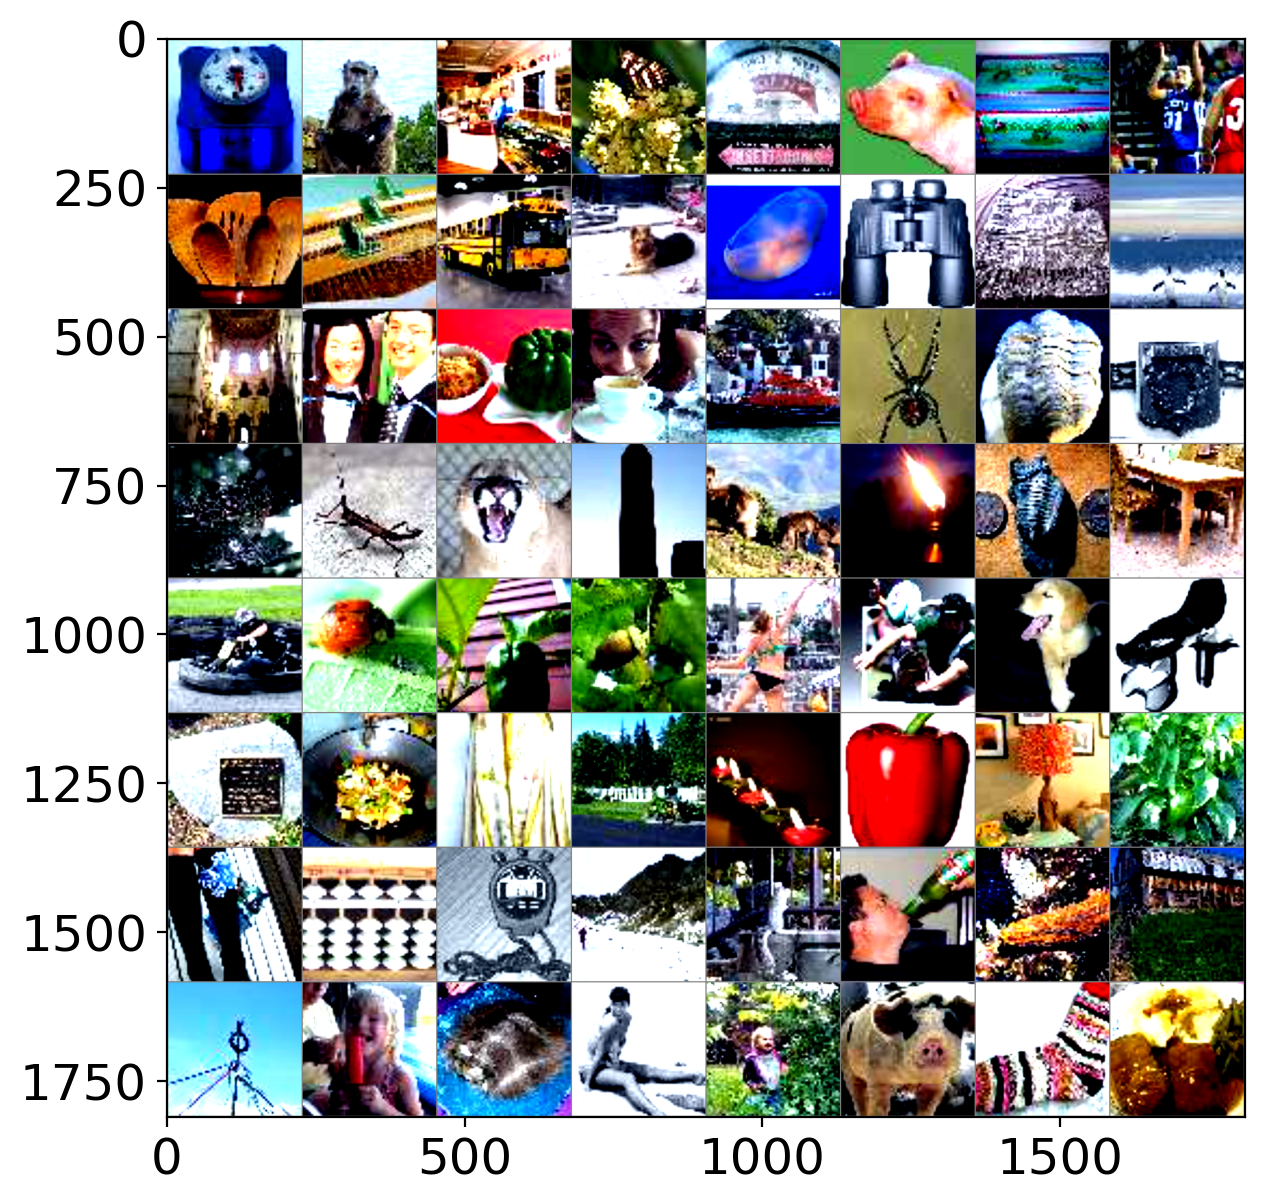

In [ ]:
# здесь выводятся картинки, если бы батч был размера 64
# батч размера 512 слишком большой для визуализации целиком

images, labels = next(iter(train_dataloader)) # из 3 семинара

plt.figure(figsize=(7,7))
# create grid of images
img_grid = torchvision.utils.make_grid(images)
# show images
matplotlib_imshow(img_grid, one_channel=False)

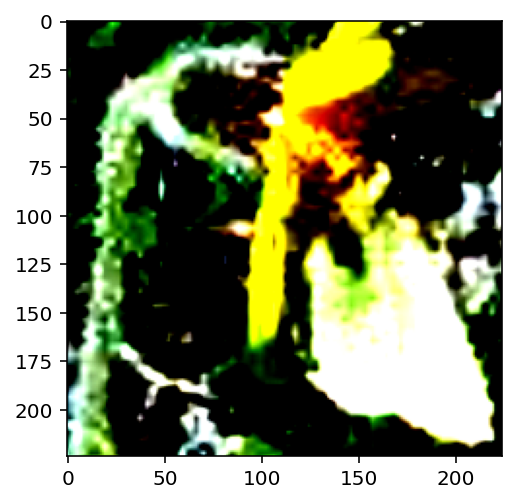

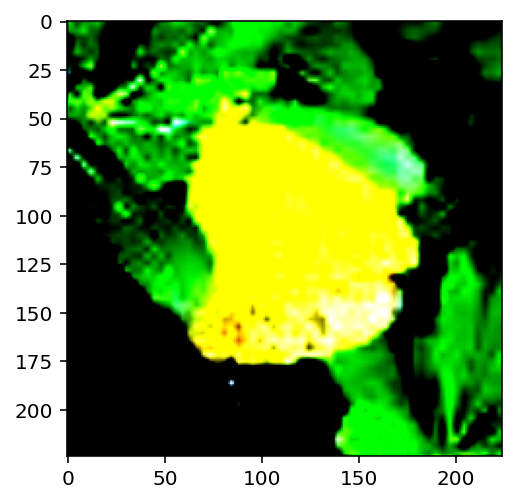

In [ ]:
# здесь можно посмотреть на картинки поближе
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

### Модель (или просто импортируйте предобученную)

Мой выбор модели пал на современную **ConvNeXt**. Я изучил статью про нее и понял, что она хорошо подойдет к нашей задаче (подробнее $-$ в отчете).

Определим модель, посмотрим на ее архитектуру, напишем для нее соответствующий класс и попробуем сделать **baseline** из случайной инициализации.

In [ ]:
model = convnext_large(weights=ConvNeXt_Large_Weights.IMAGENET1K_V1)  # то же, что и ConvNeXt_Large_Weights.DEFAULT

Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\convnext_large-ea097f82.pth
100%|██████████| 755M/755M [00:55<00:00, 14.3MB/s] 


In [ ]:
# посмотрим на модель
model

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=192, out_features=768, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=768, out_features=192, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
          (1): Permute()
          (2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

Понятно, что для нашей задачи $-$ классификации на 200 классов нужно будет изменить последний линейный слой модели, который на данный момент насчитывает 1000 выходов.

Напишем класс:

In [ ]:
# берем в качестве основы предобученную convnext
# шаблон взят из семинара № 4

class MyPretrainedConvNeXt(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = convnext_large(weights=ConvNeXt_Large_Weights.IMAGENET1K_V1)

        # меняем последний линейный слой и создаем свой новый
        self.model.classifier[2] = nn.Identity()
        self.myclassifier = nn.Linear(in_features=1536, out_features=200, bias=True)

        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        with torch.no_grad():
            features = self.model(x)
        preds = self.myclassifier(features)
        
        return preds

    def forward(self, images, target=None):
        output = self._forward(images)

        # get accuracy score and save it to self.accuracy
        if target is not None:
            loss = self.loss_func(output, target)

            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long())

        return loss

    def get_accuracy(self, reset=False):
        # return accuracy by all values till now
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()

        return self.accuracy

Попробуем создать baseline.

In [ ]:
baseline_model = MyPretrainedConvNeXt().to(device)

Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to /root/.cache/torch/hub/checkpoints/convnext_large-ea097f82.pth


  0%|          | 0.00/755M [00:00<?, ?B/s]

In [ ]:
# тест бейзлайна

convnext_baseline = baseline_model.to(device)

accuracy = evaluate_task(convnext_baseline, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")

100%|██████████| 20/20 [00:58<00:00,  2.91s/it]


Оценка за это задание составит 0.00 баллов


In [ ]:
accuracy

0.004

При случайной инициализации *accuracy* составил всего лишь 0.004, что меньше одного процента. Это соответствует случайному классификатору. Конечно, ориентироваться на это значение не стоит, но, по крайней мере, все работает.

### Тренировочный класс lightning

Определим модуль `pl.LightningModule`

In [ ]:
# модуль для интеграции преодобученной модели convnext
# источник для интеграции логера wandb: https://docs.wandb.ai/guides/integrations/lightning
# шаблон взят из семинара № 4

class MyPrentainedModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate

        # сохраняем гиперпараметры в self.hparams (автоматически логируется в wandb)
        self.save_hyperparameters(ignore=['model']) # (ignore=['model']), т.к. wandb и так следит за моделью

    def forward(self, x):
        result = self.model(x)

        return result

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.myclassifier.parameters(), lr=self.learning_rate, weight_decay=1e-8)  # параметры для optimizer, scheduler и weight_decay
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=196, eta_min=0)                       # взяты исходя из рекомеднаций авторов исследования
                                                                                                                      # источник: https://arxiv.org/abs/2201.03545
                                                                                                                      # шаг в 196 итераций соответствует одной эпохе, если 
                                                                                                                      # размер батча равен 512
                                                                                                                      # визуализация работы scheduler представлена ниже в отчете
        lr_scheduler_config = {          # определяем настройки scheduler
            "scheduler": scheduler,      # передаем scheduler
            "interval": "step",          # 'step' / 'epoch'
            "frequency": 1,              # Сколько эпох/шагов должно пройти между вызовами функции `scheduler.step()`
            "monitor": "val_accuracy",   # метрика для мониторинга scheduler типо `ReduceLROnPlateau`
            "strict": True,              # остановка обучения, если не найдена метрика для мониторинга
            "name": None,                # a custom logged name
        }
        opt_sched_dict = {
            "optimizer" : optimizer,
            "lr_scheduler" : lr_scheduler_config 
            }

        return opt_sched_dict

    def training_step(self, batch, batch_idx):
        '''возвращаем loss из одного батча'''
        # получаем предсказанные значения, loss и метрику accuracy
        _, loss, acc = self._get_preds_loss_accuracy(batch)

        # логируем loss и метрику в wandb
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_accuracy", acc, prog_bar=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        '''используется для логирования метрик на валидации'''
        # получаем предсказанные значения, loss и метрику accuracy
        preds, loss, acc = self._get_preds_loss_accuracy(batch)

        # логируем loss и метрику в wandb
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", acc, prog_bar=True)
        
        return preds

    def _get_preds_loss_accuracy(self, batch):
        '''функция для получения предсказанных значений, loss и метрики accuracy'''
        x, y = batch
        preds = self.model._forward(x)
        loss = self.model(x, y)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), y.long())
        
        return preds, loss, acc

### Logger W&B

Определим логер для wandb.

In [ ]:
# определим логер, источник: https://docs.wandb.ai/guides/integrations/lightning

wandb_logger = WandbLogger(
    project='hw-2',
    name='test-2.0',
    version='convnext-1.0',
    log_model='all')

checkpoint_callback = ModelCheckpoint(monitor='val_accuracy', mode='max')  # условие для сохранения модели: наибольшая метрика на валидации

### Тренировка

In [ ]:
# создадим модель и модуль

model = MyPretrainedConvNeXt().to(device)
wandb_logger.watch(model, log="all")

module = MyPrentainedModule(
    model,
    learning_rate=0.025118864315095822   # best lr из auto_lr_find; также хорошее значение: 5e-5
)

Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to /root/.cache/torch/hub/checkpoints/convnext_large-ea097f82.pth


  0%|          | 0.00/755M [00:00<?, ?B/s]

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
# определим Trainer

trainer = pl.Trainer(
    logger=wandb_logger,
    callbacks=[log_predictions_callback,
               checkpoint_callback],
    max_epochs=1,
    accelerator="gpu",
    auto_lr_find=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.tune(module, train_dataloader, val_dataloader)  # 0.025118864315095822 on batch 512 / 8 min

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.025118864315095822
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_f13cfaa1-81d4-4a17-bdf7-747ef00b8b2b.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint file at /content/.lr_find_f13cfaa1-81d4-4a17-bdf7-747ef00b8b2b.ckpt


{'lr_find': <pytorch_lightning.tuner.lr_finder._LRFinder at 0x7f6b7b2232d0>}

In [ ]:
trainer.fit(module, train_dataloader, val_dataloader)  # 17 min

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                 | Params
-----------------------------------------------
0 | model | MyPretrainedConvNeXt | 196 M 
-----------------------------------------------
196 M     Trainable params
0         Non-trainable params
196 M     Total params
786.151   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


### Валидация результатов задания

In [ ]:
evalmodel = model.to(device)

accuracy = evaluate_task(evalmodel, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")

100%|██████████| 20/20 [00:48<00:00,  2.43s/it]


Оценка за это задание составит 10.00 баллов


In [ ]:
accuracy

0.8565

И сразу получен требуемый результат! **`accuracy` = 0.8565** на одной эпохе обучения. Это результат хорошей подготовительной работы.

---

Проведем еще некоторые эксперименты.

Чтобы убедиться в том, что это не случайный результат, реализуем обучение аналогичной модели из случайной инициализации.

In [ ]:
# определим логер, источник: https://docs.wandb.ai/guides/integrations/lightning

wandb_logger = WandbLogger(
    project='hw-2',
    name='test-2.1',
    version='convnext-1.1',
    log_model='all')

checkpoint_callback = ModelCheckpoint(monitor='val_accuracy', mode='max')  # условие для сохранения модели: наибольшая метрика на валидации

In [ ]:
# создадим модель и модуль

model = MyPretrainedConvNeXt().to(device)
wandb_logger.watch(model, log="all")

module = MyPrentainedModule(
    model,
    learning_rate=0.025118864315095822   # best lr из auto_lr_find; также хорошее значение: 5e-5
)

Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to /root/.cache/torch/hub/checkpoints/convnext_large-ea097f82.pth


  0%|          | 0.00/755M [00:00<?, ?B/s]

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
# определим Trainer

trainer = pl.Trainer(
    logger=wandb_logger,
    callbacks=[log_predictions_callback,
               checkpoint_callback],
    max_epochs=1,
    accelerator="gpu",
    auto_lr_find=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.tune(module, train_dataloader, val_dataloader)  # 0.025118864315095822 on batch 512 / 8 min

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.025118864315095822
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_360b305f-af4c-4923-bd0f-a7ea6847c743.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint file at /content/.lr_find_360b305f-af4c-4923-bd0f-a7ea6847c743.ckpt


{'lr_find': <pytorch_lightning.tuner.lr_finder._LRFinder at 0x7f542d5c3ed0>}

In [ ]:
trainer.fit(module, train_dataloader, val_dataloader)  # 17 min

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                 | Params
-----------------------------------------------
0 | model | MyPretrainedConvNeXt | 196 M 
-----------------------------------------------
196 M     Trainable params
0         Non-trainable params
196 M     Total params
786.151   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
evalmodel = model.to(device)

accuracy = evaluate_task(evalmodel, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")

100%|██████████| 20/20 [00:48<00:00,  2.40s/it]


Оценка за это задание составит 10.00 баллов


In [ ]:
accuracy

0.8611

Результат получился даже немного выше. Теперь **`accuracy` составляет 0.8611.**

In [ ]:
wandb.finish()

Однако сейчас значения передаются в логер wandb раз в 50 итераций (по умолчанию). Учитывая, что одна эпоха на батче 512 занимает 196 итераций, логер рисует график на одной эпохе всего из 4 значений.

Было бы интересно посмотреть на процесс обучения модели более детально. **Модифицируем логер.**

In [ ]:
# определим логер, источник: https://docs.wandb.ai/guides/integrations/lightning

wandb_logger = WandbLogger(
    project='hw-2',
    name='test-2.2',
    version='convnext-1.2',
    log_model='all')

checkpoint_callback = ModelCheckpoint(monitor='val_accuracy', mode='max') # условие для сохранения модели: наибольшая метрика на валидации

In [ ]:
# создадим модель и модуль

model = MyPretrainedConvNeXt().to(device)
wandb_logger.watch(model, log="all")

module = MyPrentainedModule(
    model,
    learning_rate=0.025118864315095822  # best lr из auto_lr_find; также хорошее значение: 5e-5
)

Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to /root/.cache/torch/hub/checkpoints/convnext_large-ea097f82.pth


  0%|          | 0.00/755M [00:00<?, ?B/s]

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
# определим Trainer

trainer = pl.Trainer(
    logger=wandb_logger,
    callbacks=[log_predictions_callback,
               checkpoint_callback],
    max_epochs=1,
    accelerator="gpu",
    log_every_n_steps=3,  # логируем метрики раз 3 итерации
    auto_lr_find=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(module, train_dataloader, val_dataloader)  # 17 min

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                 | Params
-----------------------------------------------
0 | model | MyPretrainedConvNeXt | 196 M 
-----------------------------------------------
196 M     Trainable params
0         Non-trainable params
196 M     Total params
786.151   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
evalmodel = model.to(device)

accuracy = evaluate_task(evalmodel, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")

100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


Оценка за это задание составит 10.00 баллов


In [ ]:
accuracy

0.8611

`accuracy` снова составляет 0.8611, но теперь (в отчете) можно посмотреть на детальный процесс обучения модели.

In [ ]:
wandb.finish()

Также для интереса попробуем загрузить обученную модель и провести еще одну эпоху обучения.

In [ ]:
# импорт лучшей модели

run = wandb.init(project="hw-2")
artifact = run.use_artifact('rubanoww/hw-2/model-convnext-1.2:v0', type='model')
artifact_dir = artifact.download()

wandb: Downloading large artifact model-convnext-1.2:v0, 752.21MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:29.4


In [ ]:
artifact_dir

'./artifacts/model-convnext-1.2:v0'

In [ ]:
model = MyPretrainedConvNeXt().to(device)

module = MyPrentainedModule.load_from_checkpoint('/content/artifacts/model-convnext-1.2:v0/model.ckpt', model=model, pretrained=True)

Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to /root/.cache/torch/hub/checkpoints/convnext_large-ea097f82.pth


  0%|          | 0.00/755M [00:00<?, ?B/s]

In [ ]:
wandb.finish()

In [ ]:
# определим логер, источник: https://docs.wandb.ai/guides/integrations/lightning
wandb_logger = WandbLogger(
    project='hw-2',
    name='test-2.4',
    version='convnext-1.4',
    log_model='all')

checkpoint_callback = ModelCheckpoint(monitor='val_accuracy', mode='max')

In [ ]:
wandb_logger.watch(module,  log="all")

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [ ]:
newtrainer = pl.Trainer(
    logger=wandb_logger,
    callbacks=[log_predictions_callback,
              checkpoint_callback],
    max_epochs=1,
    accelerator="gpu",
    log_every_n_steps=3,  # логируем метрики раз 3 итерации
    auto_lr_find=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
newtrainer.tune(module, train_dataloader, val_dataloader)  # оптимальный lr = 6.918309709189366e-07

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=96` reached.
INFO:pytorch_lightning.tuner.lr_finder:LR finder stopped early after 96 steps due to diverging loss.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 6.918309709189366e-07
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_adfce1e5-d45a-4754-991a-02aabe36adb0.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint file at /content/.lr_find_adfce1e5-d45a-4754-991a-02aabe36adb0.ckpt


{'lr_find': <pytorch_lightning.tuner.lr_finder._LRFinder at 0x7f5246031d90>}

In [ ]:
newtrainer.fit(module, train_dataloader, val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                 | Params
-----------------------------------------------
0 | model | MyPretrainedConvNeXt | 196 M 
-----------------------------------------------
196 M     Trainable params
0         Non-trainable params
196 M     Total params
786.151   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
newevalmodel = model.to(device)

accuracy = evaluate_task(newevalmodel, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy - 0.5) / 0.34, 0, 10):.2f} баллов")

100%|██████████| 20/20 [00:47<00:00,  2.40s/it]


Оценка за это задание составит 10.00 баллов


In [ ]:
accuracy

0.861

Интересно, но метрика `accuracy` осталась без изменений. В **отчете** можно посмотреть на более детальную информацию.

In [ ]:
wandb.finish()

# Отчёт об экспериментах 

## Задание 1

#### Подготовка

В начале я работал над отладкой всего кода и проработкой общего pipeline для 1 задания.

Я создал ограниченный датасет из 256 объектов, взял батчи по 64 объекта (т.е. 1 эпоха = 4 итерации). Не делал аугментации и брал картинки без нормализации. Архитектуру также взял простейшую: 1 сверточный слой и 1 полносвязный слой.

Первый работающий запуск (пока без логера) привел к `accuracy` = 0.0166, т.е. всего 2%. Немного лучше случайного классификатора.

---

Я понял слабые места в коде и улучшил его: **добавил метрику `accuracy` на train**,
также сделал хорошую **нормализацию**, посчитав среднее и стандартное отклонение по всем каналам всех изображений из обучающей выборки. 

Я добавил классические для IMAGENET **аугментации** (Posterize, Rotate, Solarize, AutoContrast, Contrast, Equalize, Color, Invert, Sharpness, ShearX).

Также я добавил **логер** `wandb` для того, чтобы полноценно отслеживать модель во время обучения, и положил туда все метрики (**loss** на *train и validation*, а также **accuracy** на *train и validation*).

Архитектуру я пока что не менял, она осталась такой же: 1 сверточный слой и 1 полносвязный слой, для последней проверки.

Первый запуск с wandb на 1 эпохе: [ссылка](https://wandb.ai/rubanoww/hw-2/reports/train_loss-22-10-29-01-52-37---VmlldzoyODcyNDM4?accessToken=mkveezn7yeb3yxuzqus37vvr1u5dm0jbpme8s7ziu1zg1oweetexapnvnwtnbqrz).  

И далее я некоторое время занимался финальной отладкой кода на простой архитектуре: [ссылка](https://wandb.ai/rubanoww/hw-2/reports/train_loss-22-11-02-16-12-00---VmlldzoyODk3Njkz?accessToken=te8e9ykhvj8wxebeka60rs8yl71l6adrgtaf2tsor5u18g8of8x5wot2a4ayy3od). Лосс уже начал уменьшаться.

---

#### Основная архитектура

Я попробовал несколько вариантов собственной сети и понял, что будет проще взять непредобученную хорошую архитектуру известной сети. 

Я взял **resnet18** с 5-го  семинара, т.к. она достаточно глубокая, но не очень большая (обучится за разумный срок) и имеет особенность, препятствующую затуханию градиента: **skip connection**. 

Я внедрил ее в код, сделал нужное число выходов (200) и сделал батчи по 64 объекта. Научился *сохранять гиперпараметры* через wandb, а также делать *сохранение лучшей модели* на основе метрики accuracy на валидации. Также я сделал через wandb специальную табличку, в которой можно отслеживать реальные классы на валидации и те, которые прогнозирует моя модель (`wandb_logger.log_image`), правда я не до конца с ней разобрался, т.к. вместо наиболее вероятного класса моя модель выдавала, как я понимаю, вектор предсказаний на каждый класс (проблема была решена на этапе работы над 2 заданием).

Также я поставил циклический `scheduler` от 0,001 до 0 каждые 4500 итераций, о котором прочитал в статье (*Techniques for Image Classification on Tiny-ImageNet: Zach Barnes, Frank Cipollone, Tyler Romero*, ссылка: http://cs231n.stanford.edu/reports/2017/pdfs/937.pdf) и который хотел бы **продемонстрировать** ниже:

In [4]:
# кодя для иллюстрации шедулера из семинара № 4
model = torch.nn.Linear(1, 1)

def get_simple_model_optimizer():
    simple_model = torch.nn.Linear(2, 1)
    simple_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    return simple_model, simple_optimizer

# 17200 итераций = 10 эпох, т.к. в одной эпохе 1720 итераций, если батч = 64
def draw_learning_rate_curve(optimizer, scheduler):
    lrs = []
    for i in range(17200):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
    plt.grid()
    plt.plot(range(17200), lrs)

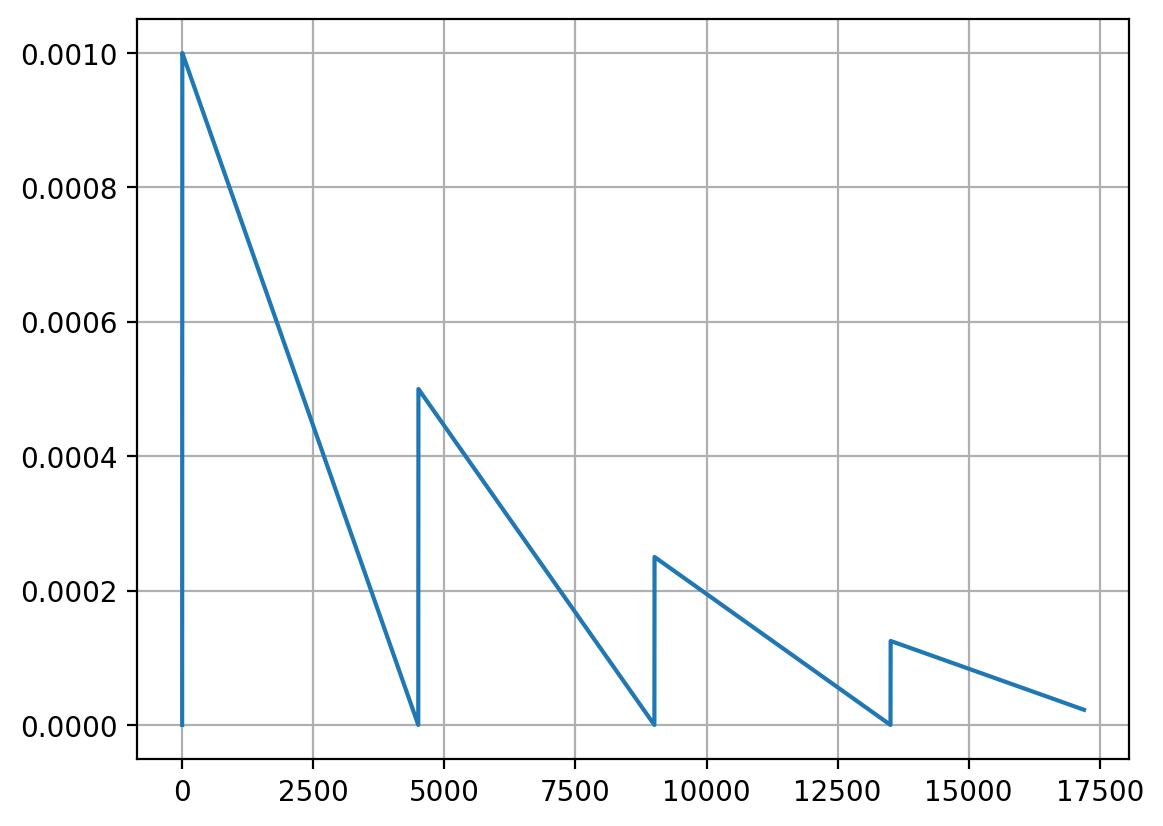

In [5]:
model, optimizer = get_simple_model_optimizer()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0,
                                                      max_lr=0.001,
                                                      step_size_up=3,
                                                      step_size_down=4500, 
                                                      verbose=False,
                                                      mode='triangular2',
                                                      cycle_momentum=False)
draw_learning_rate_curve(optimizer, scheduler)

Этот `scheduler` должен помочь (и, как я понимаю, действительно помог) периодически *"выбираться" из локальных минимумов*, поднимая `lr`, но не слишком сильно (хотя авторы статьи советовали не сокращать его, а каждый раз возвращать к значению 0,001).

Итак, я **обучил 10 эпох** на архитектуре `resnet18` с оптимизатором `adam` и обозначенным выше `scheduler`, получил неплохое качество 0.3838. [Отчет](https://wandb.ai/rubanoww/hw-2/reports/train_loss-22-10-30-22-29-33---VmlldzoyODc5MDg3?accessToken=wudsna5wwgrzxx595mc0elnp39d2hr5il3agrzzohlwb4zh6iyx3ylz372mzyjr1)  (run **"test-1"**).

Я сохранил обучившуюся модель через wandb и решил **дообучить** ее, поскольку понимал, что у этой модели есть потенциал. 

Я загрузил модель и с продолжил обучение с теми же весами и гиперпараметрами. В начале я обучил 5 эпох (run **"test-1.2"**), а затем $-$ еще 5 эпох (run **"test-1.4"**). [Отчет](https://wandb.ai/rubanoww/hw-2/reports/train_accuracy-22-10-31-01-33-35---VmlldzoyODc5NTc1?accessToken=o3gtaf1pphrz4s37w62p1vkeghedrhjd9uk3ueh1i1vw7jmwq8e92aqor96g9pwy). 

По итогам обучения модели **"test-1.2"** я получил метрику accuracy = 0.4188, а после обучения второй модели **"test-1.4"** получил **accuracy = 0.4375** $-$ практически необходимый результат.

Но я решил, что можно попробовать еще улучшить результат.

---


#### Финальная реализация

Далее последовал ряд (неудачных) экспериментов (*test-1.5, test-1.6*), в ходе которых я получал метрику accuracy, меньшую, чем 0.4375. [Отчет](https://wandb.ai/rubanoww/hw-2/reports/train_accuracy-22-11-02-16-42-08---VmlldzoyODk3ODcx?accessToken=uyawmjdh3aawf12kur50u15bjkkdc1wcqpaw7l0ig4wv2ei2p7i0cjhvg15w2f6k).

Я отталкивался от модели в реализации **"test-1.4"**, пытаясь дообучить ее. Но каждый раз я сталвивался с сильно колеблющимся лоссом, как будто я не мог спуститься в оптимум.

Поэтому я решил поменять что-то и уменьшить `lr`, а также изменить `scheduler` с циклического на монотонно убывающий (`StepLR`). И очень слабо менять его каждую итерацию.

Иллюстрация нового `scheduler`:

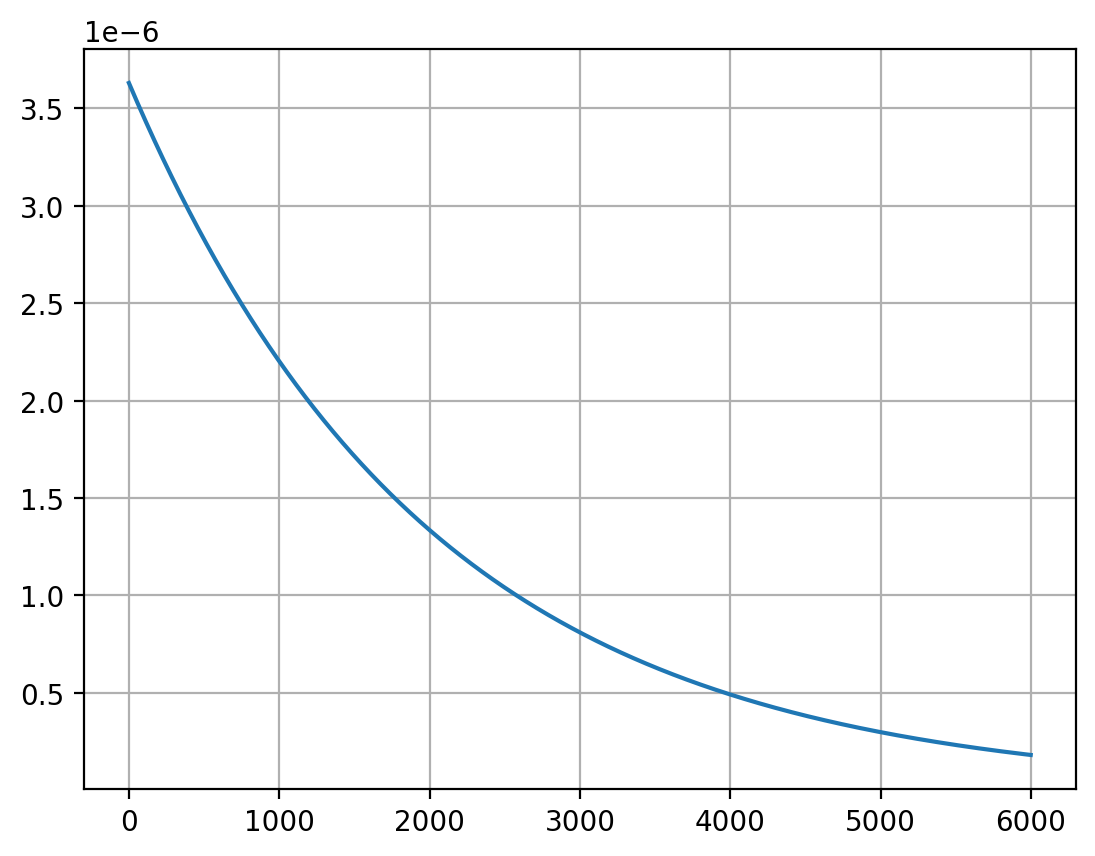

In [6]:
# иллюстрация для шедулера взята из семинара № 4

model = torch.nn.Linear(1, 1)

def get_simple_model_optimizer():
    simple_model = torch.nn.Linear(2, 1)
    simple_optimizer = torch.optim.Adam(model.parameters(), lr=3.630780547701014e-06) # лучший lr из auto_lr_find
    return simple_model, simple_optimizer

# 6000 итераций примерно соответствуют 4 эпохам
def draw_learning_rate_curve(optimizer, scheduler):
    lrs = []
    for i in range(6000):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
    plt.grid()
    plt.plot(range(6000), lrs)

model, optimizer = get_simple_model_optimizer()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9995)
draw_learning_rate_curve(optimizer, scheduler)

После этого, найдя оптимальный `lr` через `auto_lr_find`, я быстро дообучил модель всего за одну эпоху и получил необходимый результат: **accuracy = 0.4512 (run "test-1.7")**.

**Финальный отчет:**
https://wandb.ai/rubanoww/hw-2/reports/train_loss-22-10-30-22-29-33---VmlldzoyODc5MDg3?accessToken=wudsna5wwgrzxx595mc0elnp39d2hr5il3agrzzohlwb4zh6iyx3ylz372mzyjr1

*Здесь можно посмотреть на процесс обучения всех моделей, о которых говорилось выше.*

---

## Задание 2

#### Подготовительная работа

Изначально, по стопам лекции, я хотел взять в качестве предобученной сети одну из самых больших ResNet, но посмотрев на список доступных в PyTorch моделей и почитав их описания, мой выбор остановился на свежей ConvNeXt.

Я внимательно изучил материалы по ней (документацию, страницу https://pytorch.org/vision/main/models/convnext.html и статью, где она была представлена: https://arxiv.org/abs/2201.03545).

Я воспользовался советами авторов для *fine-tuning* их самой большой версии `CONVNEXT_LARGE`.
Я взял в качестве **размера батча 512**, применил **трансформацию**, которую "ждет" данная нейросеть с необходимыми параметрами нормализации и **resize**. Также я снова применил традиционные для IMAGENET **аугментации** для обучающей выборки.

Также я выбрал следующие **гиперпараметры**: `lr=5e-5` (позднее он был изменен на оптимальный с т.з. `auto_lr_find`, равный примерно 0.025), `weight_decay=1e-8`, косинусный `scheduler` с "падением" к концу каждой нечетной эпохи (это был мой выбор). При выборе данных значений я руководствовался рекомендациями авторов из статьи выше.

Далее я хотел бы продемонстрировать логику работы моего `scheduler`:

In [7]:
# иллюстрация для шедулера взята из семинара № 4

model = torch.nn.Linear(1, 1)

def get_simple_model_optimizer():
    simple_model = torch.nn.Linear(2, 1)
    simple_optimizer = torch.optim.Adam(model.parameters(), lr=5e-5) # 
    return simple_model, simple_optimizer

# 6000 итераций примерно соответствуют 4 эпохам
def draw_learning_rate_curve(optimizer, scheduler):
    lrs = []
    for i in range(2000):
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
    plt.grid()
    plt.plot(range(2000), lrs)

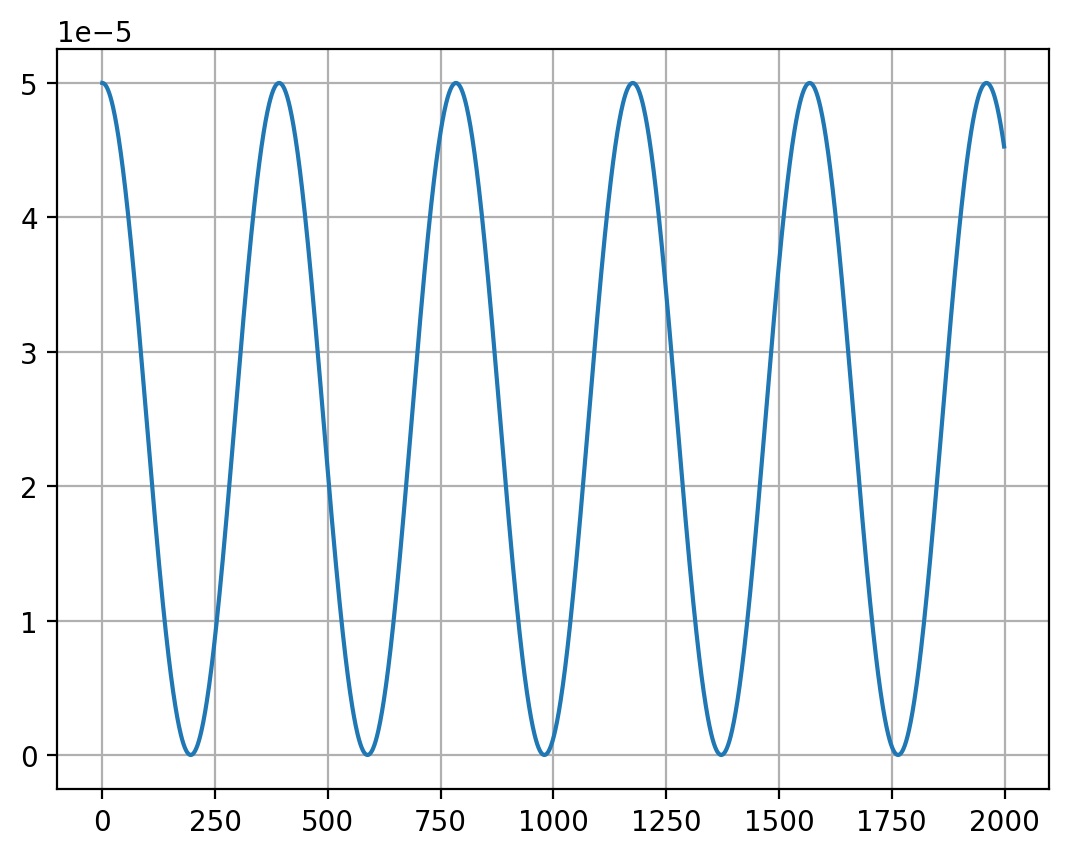

In [8]:
model, optimizer = get_simple_model_optimizer()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=196, eta_min=0) # batch 512
draw_learning_rate_curve(optimizer, scheduler)

Предполагалось, что он будет достигать минимального значения к концу четных эпох и максимальных $-$ нечетных эпох (однако в итоге хватило одной эпохи).

#### Первый запуск

Написание кода (классов модели и модуля) не заняло у меня много времени, поскольку я хорошо поработал над ним для 1 задании. Также я *исправил wandb-логер*, в котором теперь можно было смотреть, какие классы картинок на валидации предсказывает моя модель, и какие у картинок реальные классы.

Модель и батч из 512 картинок оказались такими большими, что не поместились на видеопамять моей локальной видеокарты. Поэтому модель пришлось сразу тестировать в Colab.

Итак, я решил в начале обучить модель на одной эпохе, [отчет](https://wandb.ai/rubanoww/hw-2/reports/train_accuracy-22-11-04-00-25-51---VmlldzoyOTA3Njk2?accessToken=08rhqv3g261n47gf6xpj0oqer88gkjovrg7vthrhdf43jtxr9j95p4qfv07xeyqy) (run **"test-2.0"**).

**Качество сразу получилось на 10**: `accuracy` составила 0.8565. Интересно, что впервые GPU, который я использовал в Colab (NVIDIA A100) был загружен на 100%.

---

#### Дальнейшие эксперименты

Честно говоря, я был несколько удивлен такому хорошему результату буквально с первого раза (несмотря на то, что перед этим была проделана большая подготовительная работа).
Поэтому я решил еще раз запустить данную модель из случайной инициализации.

*Во второй раз я получил качество даже немного выше: `accuracy` = 0.8611 (run **"test-2.1"**).*

Однако я понял, что из-за того, что я взял большие батчи (512), логер слишком редко давал значения для графиков (раз в 50 итераций при том, что одна эпоха занимала 196 итераций). График был довольно скупым на выводы.

Поэтому я решил еще раз запустить модель из случайной инициализации, но попросив логер логировать значения раз в 3 итерации (run **"test-2.2"**).
На [отчете](https://wandb.ai/rubanoww/hw-2/reports/train_accuracy-22-11-04-00-30-51---VmlldzoyOTA3NzE3?accessToken=092ljwtd27y05cqrzonprlvasnnziru16cgxucjm016rwzqbgl3dsgc5ezu2by3t) можно увидеть, что лосс моделей из случайной инициализации быстро падает и достигает некоторого плато. При этом интересно, что значение accuracy на обучающей выборке было ниже, чем на валидационной.

Далее мне стало интересно попробовать доучить еще одну эпоху для данных моделей. Я взял веса и значение оптимизатора последней модели **"test-2.2"** и запустил еще одну эпоху обучения (run **"test-2.4"**) в отчете. Интересно, что, по понятным причинам, лосс изначально был меньше, но в итоге он так и не смог опуститься еще ниже. В результате `accuracy` у этой модели получился точно таким же: 0.8611.

---

Кроме того, в этом задании мне удалось донастроить логер wandb и выдавать **таблицу** следующего вида: [отчет](https://wandb.ai/rubanoww/hw-2/reports/sample_images-22-11-04-00-36-23---VmlldzoyOTA3NzQ1?accessToken=6zgjzupskakcmo2s5v0w2a9a4wviai1wz5c37gud158qgr4yg8cxc8q6wn57gqax). 

Здесь можно посмотреть на *реальные и предсказанные классы картинок из первого валидационного батча* (первые 20). Видно, что модель не ошибается ни на одной из них, данный класс $-$ бабочки.

> Спасибо и извините, если занял у вас много времени на свою работу! \
> Это было очень интересно!